# Gravity
In this notebook, we look at how gravity affects system properties such as number density and temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
from scipy.optimize import minimize

import billiards as bl

In [2]:
# Setup the simulation
L = 400.0  # Simulation width
bottom_left = np.array([-L/2, -L/2])
top_right = np.array([L/2, L/2])

sim = bl.PySim(bottom_left, top_right, 190, 190)
sim.g = np.array([0.0, -0.04])

# Number, speed, masses, radii of discs
N_discs = 10_000
v = 2.0
m = 1.0
R = 1.0

sim.add_random_discs(bottom_left, top_right, N_discs, m, R, v=v, pos_allocation='grid')

In [3]:
# Plot the initial state
def create_state_plot(cur_pos, R, bottom_left, top_right):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.gca()
    
    xlim = [bottom_left[0], top_right[0]]
    ylim = [bottom_left[1], top_right[1]]
    plt.xlim(xlim)
    plt.ylim(ylim)

    # Use EllipseCollection instead of scatter as discs will definitely be the correct size
    # Like scatter we can only use EllispeCollection in an non-interactive context
    # Note Ellipses are defined in terms of width/height so we must double the radius
    ellipse_col = EllipseCollection(widths=2*R, 
                                    heights=2*R, 
                                    angles=0.0, 
                                    units='x',
                                    offsets=cur_pos,
                                    offset_transform=ax.transData, 
                                    alpha=0.5)

    ax.add_collection(ellipse_col)
    
    ax.set_aspect('equal')
    plt.xlabel("x")
    plt.ylabel("y", rotation=0)

We first advance the simulation so that is (hopefully) has reached equilibrium. We then advance in small intervals and record the current state.

In [4]:
# Run the simulation for a bit, only interested in the final state, so no need to record events
sim.advance(10_000_000, 10000.0, False)
print(f"Simulation ended at {sim.current_time}")

Simulation ended at 1092.5382441980773


In [5]:
N_intervals = 20
t_interval = 5.0
t_events = 200_000 # enough so we should advance at least t_interval
state_dict = {
    'r_cor': np.empty((N_intervals, N_discs, 2), dtype=np.float64),
    'v_cor': np.empty((N_intervals, N_discs, 2), dtype=np.float64),
    't': np.empty(N_intervals, dtype=np.float64),
}

# Advance the simulation
for ind in range(N_intervals):
    sim.advance(t_events, sim.current_time+t_interval, False)

    # correct the current state position and velocity
    cur_state = sim.current_state
    cur_pos = cur_state['r']
    cur_t = cur_state['t']
    cur_v = cur_state['v']
    cur_R = cur_state['R']
    
    dt = (sim.current_time - cur_t)[:, np.newaxis]
    cur_pos += cur_v*dt + sim.g*(dt*dt/2.0)
    cur_v += sim.g*dt

    # add it to our list
    state_dict['r_cor'][ind] = cur_pos
    state_dict['v_cor'][ind] = cur_v
    state_dict['t'][ind] = sim.current_time

# Get flatteneds array of samples
r_samples = state_dict['r_cor']
r_samples = r_samples.reshape(-1, r_samples.shape[-1])
v_samples = state_dict['v_cor']
v_samples = v_samples.reshape(-1, v_samples.shape[-1])

Let's plot the current state to see how the inclusion of gravity has affected the simulation

In [ ]:
cur_state = sim.current_state
cur_R = cur_state['R']

cur_pos = state_dict['r_cor'][-1]
cur_v = state_dict['v_cor'][-1]

_ = create_state_plot(cur_pos, cur_R, bottom_left, top_right)

Now we consider the speed distribution and estimate the temeprature.

In [7]:
def get_kB_Tfrom_dist(speeds):
    """Estimates kB_T from an array of speeds"""

    bin_vals, bins = np.histogram(speeds, bins=10, density=True)

    def opt_f(kB_T):
        int_prob = np.exp(-m/(2*kB_T)*bins**2)
        
        diff = int_prob[:-1] - int_prob[1:]

        bin_areas = bin_vals*(bins[1:]-bins[:-1])

        return np.sum((diff - bin_areas)**2)
        
    return minimize(opt_f, 2.0)

In [8]:
# Flatten array along first axis
v_samples = state_dict['v_cor']
speeds = v_samples.reshape(-1, v_samples.shape[-1])
speeds = np.linalg.norm(speeds, axis=1)

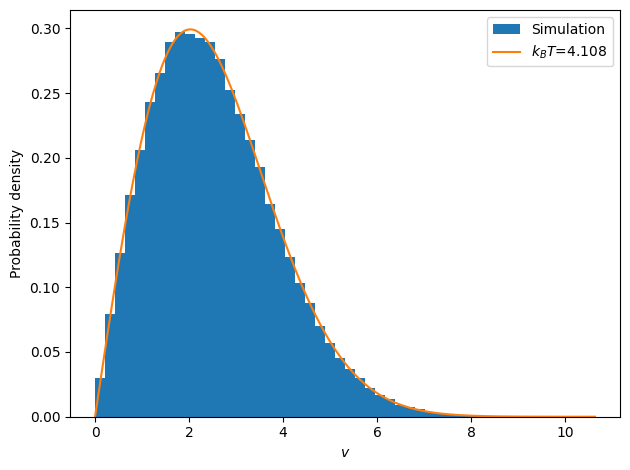

In [9]:
kB_T = get_kB_Tfrom_dist(speeds)['x'][0]

bin_vals, bins, _ = plt.hist(speeds, bins=50, density=True, label="Simulation")

speeds_arr = np.linspace(0.0, bins[-1], 1000)
exp_dist = m*speeds_arr/kB_T * np.exp(-(m/(2*kB_T)) * speeds_arr**2)

plt.plot(speeds_arr, exp_dist, label=f"$k_B T$={kB_T:.3f}")

plt.xlabel("$v$")
plt.ylabel("Probability density")

plt.legend()
plt.tight_layout()
plt.show()

Now we explore how particle number density varies with height. 

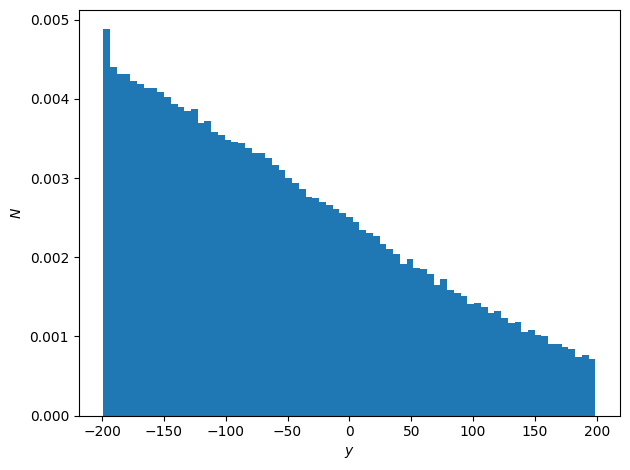

In [10]:
bin_vals, bins, _ = plt.hist(r_samples[:, 1], bins='auto', density=True)

plt.xlabel("$y$")
plt.ylabel("$N$")
plt.tight_layout()
plt.show()